In [81]:
# ipython py_spec_20200605.py
###==================================================
import cdflib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

from astropy.time import TimeDelta, Time
from astropy import units as u
from datetime import datetime
from datetime import timedelta
import time

import scipy
from scipy import io

from scipy.optimize import fsolve
import math
from sympy import symbols, nonlinsolve, sqrt, S, solveset

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
#####==================================================time starts   

tim_start=Time('2020-06-05 09:20:00.0000',format='iso',scale='tt')
#tim_start=Time('2021-09-12 17:30:00.0000',format='iso',scale='tt')


t_2020 = datetime(2020,1,1,0,0,0)  # Get timezone naive now
tsec_2020 = t_2020.timestamp()
t_input=datetime(2020,6,5,9,20,0)
tsec_input=t_input.timestamp()-tsec_2020+np.arange(1)*3600.*24.*1.


tim_1970=Time('1970-01-01 00:00:00.0000',format='iso',scale='tt')
tim_0000=Time('0000-01-01 00:00:00.0000',format='iso',scale='tt')
tim_2000=Time('2000-01-01 12:00:00.0000',format='iso',scale='tt')

trange=[0,40*60]
frange=[0.1,16.]
drange=[1e2,1e7]


event='event20200605'

In [84]:
import cdflib

In [85]:
#####==================================================PSP data prep   
###==================================================data for hfr
file_hfr='./psp/psp_l3_fld_hfr_20200605_v01.cdf'
psp_cdf = cdflib.CDF(file_hfr)
info = psp_cdf.cdf_info()

sp_hfr  =psp_cdf.varget('psd_sfu')
freq_hfr=psp_cdf.varget('frequency')
tim_hfr=psp_cdf.varget('epoch')

tim_hfr=tim_hfr/1e9

###==================================================data for lfr
file_lfr='./psp/psp_l3_fld_lfr_20200605_v01.cdf'
psp_cdf = cdflib.CDF(file_lfr)
info = psp_cdf.cdf_info()

sp_lfr  =psp_cdf.varget('psd_sfu')
freq_lfr=psp_cdf.varget('frequency')
tim_lfr=psp_cdf.varget('epoch')


###==================================================data for hfr+lfr
tim_lfr=tim_lfr[1:]/1e9
sp_lfr=sp_lfr[1:,:]

tim_psp=tim_lfr
tim_psp=tim_psp-(tim_start-tim_2000).sec
tim_psp_ind0=np.argmin(np.abs(tim_psp))

sp_psp=np.zeros((len(tim_psp), len(freq_lfr)+len(freq_hfr)), dtype = float)
sp_psp[:,0:len(freq_lfr)]=sp_lfr[0:len(tim_psp),:]
sp_psp[:,len(freq_lfr):]=sp_hfr[0:len(tim_psp),:]

freq_psp=np.zeros((len(freq_lfr)+len(freq_hfr)), dtype = float)
freq_psp[0:len(freq_lfr)]=freq_lfr
freq_psp[len(freq_lfr):]=freq_hfr

sp_psp=sp_psp[tim_psp_ind0:,:]
tim_psp=tim_psp[tim_psp_ind0:]
freq_psp=freq_psp/1e3


# #####==================================================Solar orbiter data prep   
file_solo='./solo_l3_rpw_hfr_20200605_v01.cdf'
# read data
solo_cdf = cdflib.CDF(file_solo)
info = solo_cdf.cdf_info()

sp_solo  =solo_cdf.varget('psd_sfu')
freq_solo=solo_cdf.varget('frequency')#(TNR, 4-245 kHz)
tim_solo =solo_cdf.varget('epoch')


freq_solo=freq_solo/1e3#000.
tim_solo=tim_solo/1e9


tim_solo=tim_solo-(tim_start-tim_2000).sec
tim_solo_ind0=np.argmin(np.abs(tim_solo))

sp_solo=sp_solo[tim_solo_ind0:,:]
tim_solo=tim_solo[tim_solo_ind0:]



#####==================================================Stereo A data prep   
file_stereo='./sta_l3_wav_hfr_20200605_v01.cdf'
# read data from krupar

stereo_cdf = cdflib.CDF(file_stereo)
info = stereo_cdf.cdf_info()

sp_stereo  =stereo_cdf.varget('psd_sfu')
freq_stereo=stereo_cdf.varget('frequency')
tim_stereo=stereo_cdf.varget('epoch')

freq_stereo=freq_stereo/1e3#000.
tim_stereo=tim_stereo/1e9


tim_stereo=tim_stereo-(tim_start-tim_2000).sec
tim_stereo_ind0=np.argmin(np.abs(tim_stereo))

sp_stereo=sp_stereo[tim_stereo_ind0:,:]
tim_stereo=tim_stereo[tim_stereo_ind0:]

#sp_stereo=np.power(10.,sp_stereo/10.)



#####==================================================Wind data prep   
file_wind='./wind_l3_wav_rad_20200605_v01.cdf'
# read data
wind_cdf = cdflib.CDF(file_wind)
info = wind_cdf.cdf_info()

sp_wind  =wind_cdf.varget('psd_sfu')
freq_wind=wind_cdf.varget('frequency')#(TNR, 4-245 kHz)
tim_wind=wind_cdf.varget('epoch')


freq_wind=freq_wind/1e3#000.
tim_wind=tim_wind/1e9


tim_wind=tim_wind-(tim_start-tim_2000).sec
tim_wind_ind0=np.argmin(np.abs(tim_wind))

sp_wind=sp_wind[tim_wind_ind0:,:]
tim_wind=tim_wind[tim_wind_ind0:]



C:\Users\Pjer1\AppData\Local\Temp\ipykernel_76488\3001615229.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ph1=ph.pcolormesh(tim_psp, freq_psp/1e3, sp_psp.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_76488\3001615229.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ph1=ph.pcolormesh(tim_solo, freq_solo/1e3, sp_solo.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')


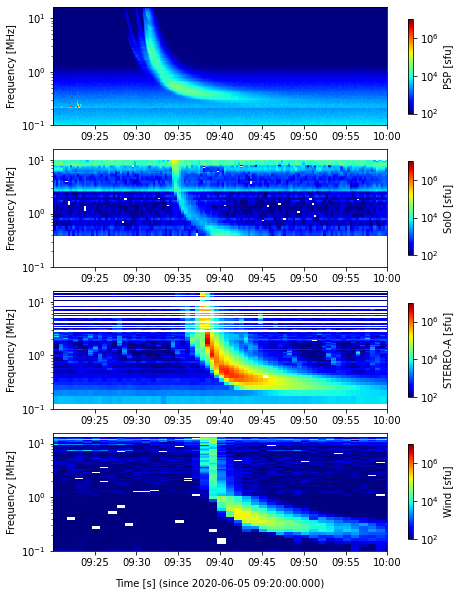

In [86]:

###====================plot1-1: spectrum PSP
fig = plt.figure(figsize=(7.5, 10.))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[2.5, 2.5,2.5,2.5])
ph = fig.add_subplot(gs[0, 0])

ph1=ph.pcolormesh(tim_psp, freq_psp/1e3, sp_psp.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')
ph.set_xlabel('Time [s] (since '+tim_start.iso+')', labelpad=10)
ph.set_ylabel('Frequency [MHz]')
ph.set_xlim(trange)
ph.set_ylim(frange)
ph.set_yscale('log')
plt.xticks([300,600,900,1200,1500,1800,2100,2400], ['09:25','09:30','09:35','09:40','09:45','09:50','09:55','10:00'])

cbar =plt.colorbar(ph1,ax=ph, shrink=0.8, pad=0.05)
cbar.set_label('PSP [sfu]', fontsize=10)




###====================plot1-2: spectrum SOLO
ph = fig.add_subplot(gs[1, 0])#,title='Spectrum'
ph1=ph.pcolormesh(tim_solo, freq_solo/1e3, sp_solo.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')
ph.set_xlabel('Time [s] (since '+tim_start.iso+')', labelpad=10)
ph.set_ylabel('Frequency [MHz]')
ph.set_xlim(trange)
ph.set_ylim(frange)
ph.set_yscale('log')
plt.xticks([300,600,900,1200,1500,1800,2100,2400], ['09:25','09:30','09:35','09:40','09:45','09:50','09:55','10:00'])

cbar =plt.colorbar(ph1,ax=ph, shrink=0.8, pad=0.05)
cbar.set_label('SolO [sfu]', fontsize=10)




###====================plot1-3: spectrum STEREO
ph = fig.add_subplot(gs[2, 0])#

ph1=ph.pcolormesh(tim_stereo, freq_stereo/1e3, sp_stereo.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')

ph.set_xlabel('Time [s] (since '+tim_start.iso+')', labelpad=10)
ph.set_ylabel('Frequency [MHz]')
ph.set_xlim(trange)
ph.set_yscale('log')
ph.set_ylim(frange)
plt.xticks([300,600,900,1200,1500,1800,2100,2400], ['09:25','09:30','09:35','09:40','09:45','09:50','09:55','10:00'])


cbar =plt.colorbar(ph1,ax=ph, shrink=0.8, pad=0.05)
cbar.set_label('STEREO-A [sfu]', fontsize=10)






###====================plot1-4: spectrum
ph = fig.add_subplot(gs[3, 0])#
ph1=ph.pcolormesh(tim_wind, freq_wind[0:280]/1e3, sp_wind[:,0:280].T, norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]),cmap='jet')
ph.set_xlabel('Time [s] (since '+tim_start.iso+')', labelpad=10)
ph.set_ylabel('Frequency [MHz]')
ph.set_xlim(trange)
ph.set_yscale('log')
ph.set_ylim(frange)
plt.xticks([300,600,900,1200,1500,1800,2100,2400], ['09:25','09:30','09:35','09:40','09:45','09:50','09:55','10:00'])

cbar =plt.colorbar(ph1,ax=ph, shrink=0.8, pad=0.05)
cbar.set_label('Wind [sfu]', fontsize=10)



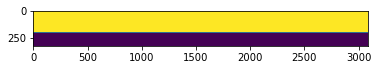

In [88]:
plt.imshow(sp_solo.T)

In [80]:

np.savez('event2022', t_psp = tim_psp,f_psp=freq_psp/1e3, ds_psp= sp_psp,
t_solo = tim_solo,f_solo =  freq_solo/1e3,ds_solo =  sp_solo.T,
t_sta=tim_stereo, f_sta=freq_stereo/1e3, ds_sta=sp_stereo.T,
t_wind=tim_wind, f_wind=freq_wind[0:280]/1e3, ds_wind=sp_wind[:,0:280].T,
t_start=mdates.date2num(tim_start.datetime),trange = trange)


In [79]:
tim_start

<Time object: scale='tt' format='iso' value=2020-06-05 09:20:00.000>

18418.38888888889

In [59]:
import matplotlib.dates as mdates

In [71]:
tim_psp[-1]

52859.20670557022

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_76488\1690011465.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ph1=ph.pcolormesh(tim_psp, freq_psp/1e3, sp_psp.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')


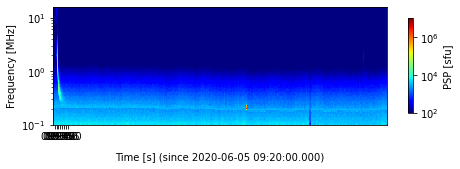

In [72]:
fig = plt.figure(figsize=(7.5, 10.))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[2.5, 2.5,2.5,2.5])
ph = fig.add_subplot(gs[0, 0])

ph1=ph.pcolormesh(tim_psp, freq_psp/1e3, sp_psp.T,norm=mcolors.LogNorm(vmin=drange[0], vmax=drange[1]), cmap='jet')
ph.set_xlabel('Time [s] (since '+tim_start.iso+')', labelpad=10)
ph.set_ylabel('Frequency [MHz]')
#ph.set_xlim(trange)
ph.set_ylim(frange)
ph.set_yscale('log')
plt.xticks([300,600,900,1200,1500,1800,2100,2400], ['09:25','09:30','09:35','09:40','09:45','09:50','09:55','10:00'])

cbar =plt.colorbar(ph1,ax=ph, shrink=0.8, pad=0.05)
cbar.set_label('PSP [sfu]', fontsize=10)
